In [1]:
%matplotlib inline
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDRegressor, Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
from datetime import date
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from pathlib import Path
import sklearn.metrics 
data_dir = Path("datasets")
filepath = data_dir / 'big mart sales' / 'data.csv'
data = pd.read_csv('data.csv')

# Data description:

In [2]:
data.shape

(8523, 12)

We have 12 columns and 8523 rows .

In [3]:
data.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


In [4]:
data = data.rename(columns=str.lower)

In [5]:
target='item_outlet_sales'
features=[col for col in data.columns if col!=target]
print(len(features), features)

11 ['item_identifier', 'item_weight', 'item_fat_content', 'item_visibility', 'item_type', 'item_mrp', 'outlet_identifier', 'outlet_establishment_year', 'outlet_size', 'outlet_location_type', 'outlet_type']


In [6]:
data.dtypes

item_identifier               object
item_weight                  float64
item_fat_content              object
item_visibility              float64
item_type                     object
item_mrp                     float64
outlet_identifier             object
outlet_establishment_year      int64
outlet_size                   object
outlet_location_type          object
outlet_type                   object
item_outlet_sales            float64
dtype: object

In [7]:
numeric_ = ["outlet_establishment_year","item_mrp","item_visibility","item_weight"]
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']

In [8]:
data.describe()

,item_weight,item_visibility,item_mrp,outlet_establishment_year,item_outlet_sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Item_Visibility has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0.
Outlet_Establishment_Years vary from 1985 to 2009. The values might not be apt in this form. Rather, if we can convert them to how old the particular store is, it should have a better impact on sales.

In [9]:
data.loc[data["item_visibility"] ==  0,:] 

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
3,FDX07,19.200,Regular,0.0,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.0,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
10,FDY07,11.800,Low Fat,0.0,Fruits and Vegetables,45.5402,OUT049,1999,Medium,Tier 1,Supermarket Type1,1516.0266
32,FDP33,18.700,Low Fat,0.0,Snack Foods,256.6672,OUT018,2009,Medium,Tier 3,Supermarket Type2,3068.0064
...,...,...,...,...,...,...,...,...,...,...,...,...
8480,FDQ58,NaN,Low Fat,0.0,Snack Foods,154.5340,OUT019,1985,Small,Tier 1,Grocery Store,459.4020
8484,DRJ49,6.865,Low Fat,0.0,Soft Drinks,129.9652,OUT013,1987,High,Tier 3,Supermarket Type1,2324.9736
8486,FDR20,20.000,Regular,0.0,Fruits and Vegetables,46.4744,OUT010,1998,NaN,Tier 3,Grocery Store,45.2744
8494,NCI54,15.200,Low Fat,0.0,Household,110.4912,OUT017,2007,NaN,Tier 2,Supermarket Type1,1637.8680


In [10]:
#Print frequency of categories
for col in categorical_columns:
    print(f'\nFrequency of Categories for varible %s'%col)
    print(data[col].value_counts())


Frequency of Categories for varible item_identifier
FDG33    10
FDW13    10
FDX20     9
NCB18     9
FDX04     9
         ..
FDO33     1
FDC23     1
FDN52     1
FDK57     1
FDT35     1
Name: item_identifier, Length: 1559, dtype: int64

Frequency of Categories for varible item_fat_content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: item_fat_content, dtype: int64

Frequency of Categories for varible item_type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: item_type, dtype: int64

Frequency of Categories for varible 

### distribution of the labels

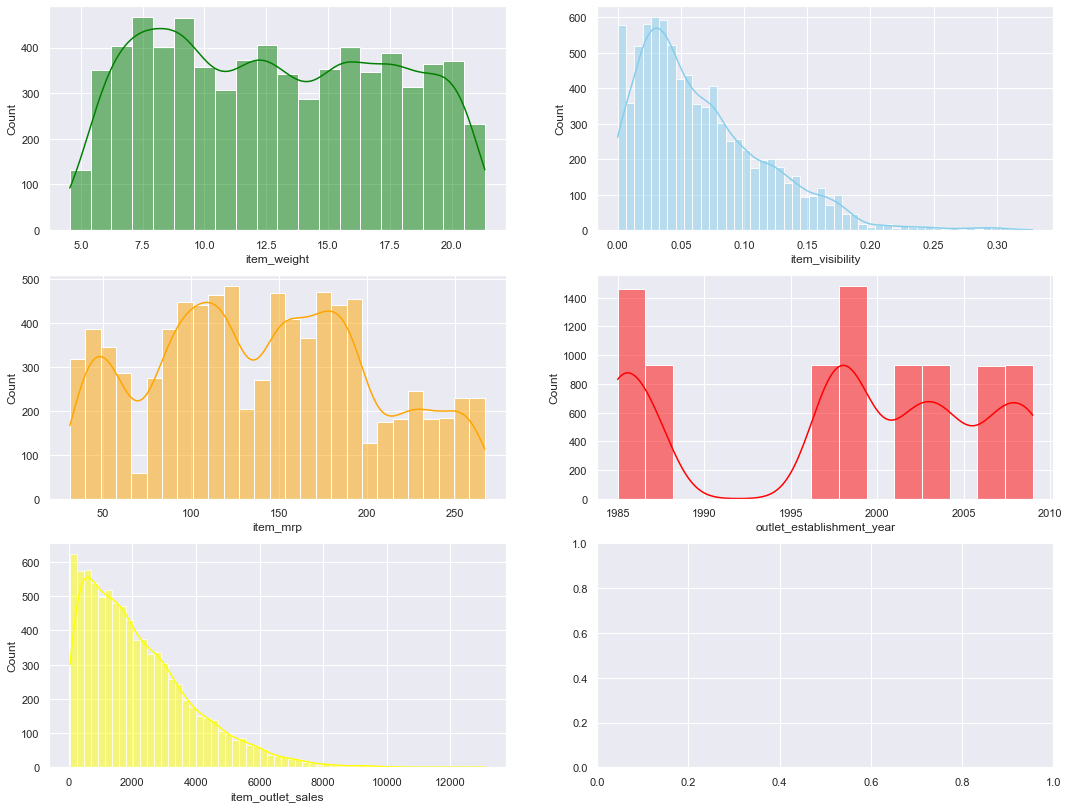

In [11]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(3, 2, figsize=(18, 14))

sns.histplot(data=data, x="item_weight", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=data, x="item_visibility", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=data, x="item_mrp", kde=True, ax=axs[1, 0], color='orange')
sns.histplot(data=data, x="outlet_establishment_year", kde=True, ax=axs[1, 1], color='red')
sns.histplot(data=data, x="item_outlet_sales", kde=True, ax=axs[2, 0], color='yellow');

It can be seen that the distribution of "Item_Weight", "Item_MRP" and "Outlet_Establishment_Year" is normal.Therefore, no outliers detected in these columns.On the other hand, in "Item_Visibility" and "Item_Outlet_Sales" column, it can be seen that the distribution has a long right tail. also it can bee seen because the mean position is on the right side of the Distribution.in addition, from "Item_Visibility" column, it can be seen that there are outliers in this column and the minimum value in this column is 0.

### missing values?

In [12]:
data.isna().mean()

item_identifier              0.000000
item_weight                  0.171653
item_fat_content             0.000000
item_visibility              0.000000
item_type                    0.000000
item_mrp                     0.000000
outlet_identifier            0.000000
outlet_establishment_year    0.000000
outlet_size                  0.282764
outlet_location_type         0.000000
outlet_type                  0.000000
item_outlet_sales            0.000000
dtype: float64

There are  missing values here, item_whwight is actually  have missing (17%) missing values and outlet_size have (28%) missing values.

## 4.e

I think the variable outlet_3 and outlet_2 can be merged. As you can see in the Describe above, it seems like all the values they get from the column outlet_size are medium. Therefore I will check this and if it is true I will do another check. I will check if the average sales of the products is similar. Finally I will decide whether to merge them, according to the results.

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: outlet_type, dtype: int64

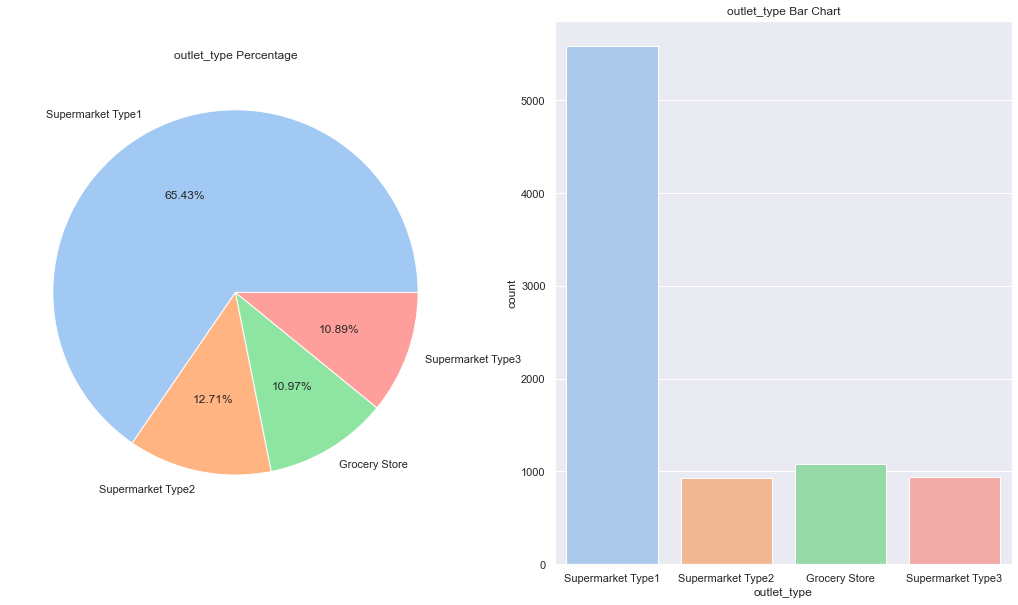

In [13]:
colors=sns.color_palette('pastel')
labels=data['outlet_type'].dropna().unique()

plt.figure(figsize=(18,10))

plt.subplot(1,2,1)
plt.title('outlet_type Percentage')
plt.pie(data['outlet_type'].value_counts(), 
        labels=labels, 
        colors=colors, 
        autopct='%.2f%%')

plt.subplot(1,2,2)
plt.title('outlet_type Bar Chart')
sns.countplot(x="outlet_type", data=data, palette=colors)

data.outlet_type.value_counts(dropna=False)

Small    1.0
Name: outlet_size, dtype: float64

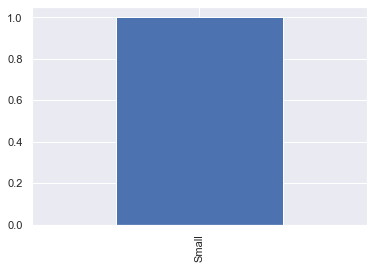

In [14]:
Grocry = data.loc[data["outlet_type"] == "Grocery Store",:]["outlet_size"]
Grocry.value_counts(normalize=True).plot(kind='bar');
Grocry.value_counts(normalize=True)

Small     0.499731
High      0.250403
Medium    0.249866
Name: outlet_size, dtype: float64

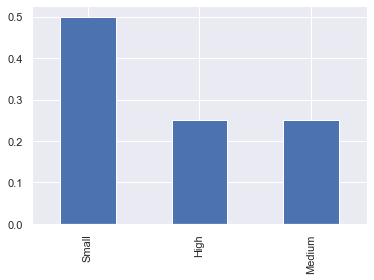

In [15]:
outlet_1 = data.loc[data["outlet_type"] == "Supermarket Type1",:]["outlet_size"]
outlet_1.value_counts(normalize=True).plot(kind='bar');
outlet_1.value_counts(normalize=True)

Medium    1.0
Name: outlet_size, dtype: float64

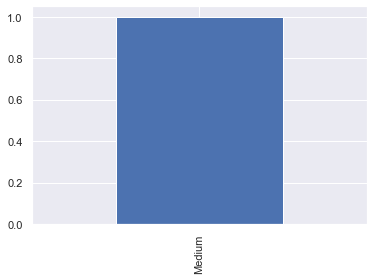

In [16]:
outlet_2 = data.loc[data["outlet_type"] == "Supermarket Type2",:]["outlet_size"]
outlet_2.value_counts(normalize=True).plot(kind='bar');
outlet_2.value_counts(normalize=True)

Medium    1.0
Name: outlet_size, dtype: float64

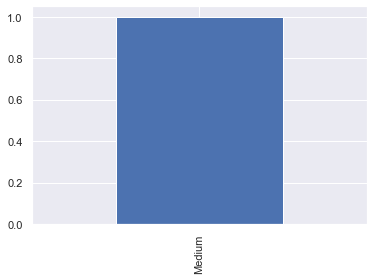

In [17]:
outlet_3 = data.loc[data["outlet_type"] == "Supermarket Type3",:]["outlet_size"]
outlet_3.value_counts(normalize=True).plot(kind='bar');
outlet_3.value_counts(normalize=True)

In [18]:
out_2 = data.loc[data["outlet_type"] == "Supermarket Type2",:]["item_outlet_sales"].mean()
out_3 = data.loc[data["outlet_type"] == "Supermarket Type3",:]["item_outlet_sales"].mean()
print(f'When, outlet_type = Supermarket Type2 the Average of item_outlet_sales is: {out_2}\nWhen, outlet_type = Supermarket Type3 the Average of item_outlet_sales is: {out_3}')

When, outlet_type = Supermarket Type2 the Average of item_outlet_sales is: 1995.4987392241392
When, outlet_type = Supermarket Type3 the Average of item_outlet_sales is: 3694.038557647059


You can see that the result of the averages is very different so I decided to leave the column outlet_type as it is and not connect between Supermarket Type2 and Supermarket Type3.

Item_Fat_Content: Some of ‘Low Fat’ values mis-coded as ‘low fat’ and ‘LF’. Also, some of ‘Regular’ are mentioned as ‘regular’.
Item_Type: all categories have substantial numbers. It looks like combining them can give better results.

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: item_fat_content, dtype: int64

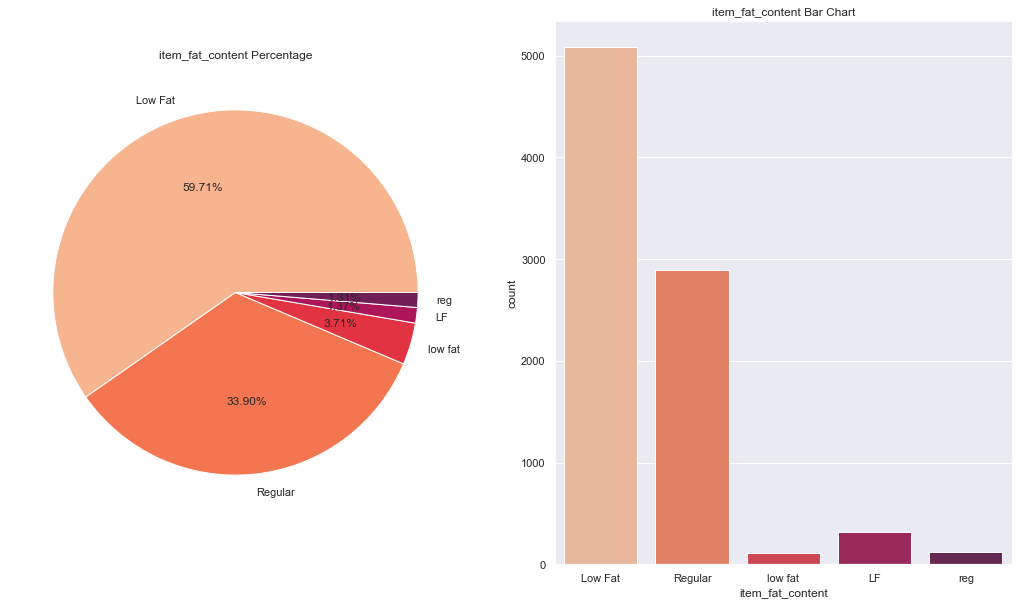

In [19]:
colors=sns.color_palette('rocket_r')
labels=data['item_fat_content'].dropna().unique()

plt.figure(figsize=(18,10))

plt.subplot(1,2,1)
plt.title('item_fat_content Percentage')
plt.pie(data['item_fat_content'].value_counts(), 
        labels=labels, 
        colors=colors, 
        autopct='%.2f%%')

plt.subplot(1,2,2)
plt.title('item_fat_content Bar Chart')
sns.countplot(x="item_fat_content", data=data, palette=colors)

data.item_fat_content.value_counts(dropna=False)

1. It can be seen that most of the products are categorized as “Low Fat” products with a percentage of 59.71%.
2. It can be seen that there are inconsistent values have the same meaning but in different values, such as “LF”, “low fat”, and “reg”.

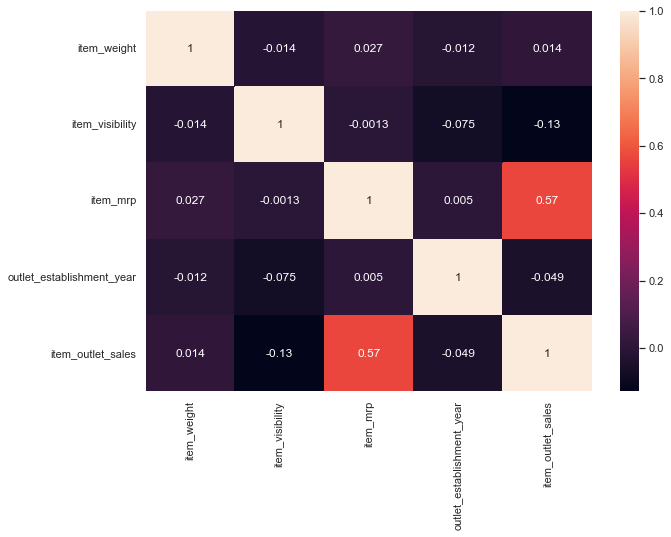

In [20]:
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(), cmap='rocket', annot=True);

It can be seen we have high and positive correlation between item_mrp and item_outlet_sales(our prediction).

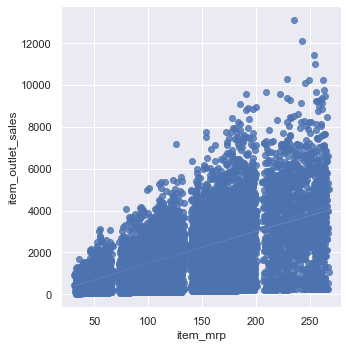

In [21]:
sns.lmplot(x='item_mrp',y='item_outlet_sales',data=data)

When item price increase the sales increase with it. 

We saw 28% missing values in outlet_size. I will now explore in more, how this can be filled especially since I know this is not a column which contains numeric variables.

Medium    2793
NaN       2410
Small     2388
High       932
Name: outlet_size, dtype: int64

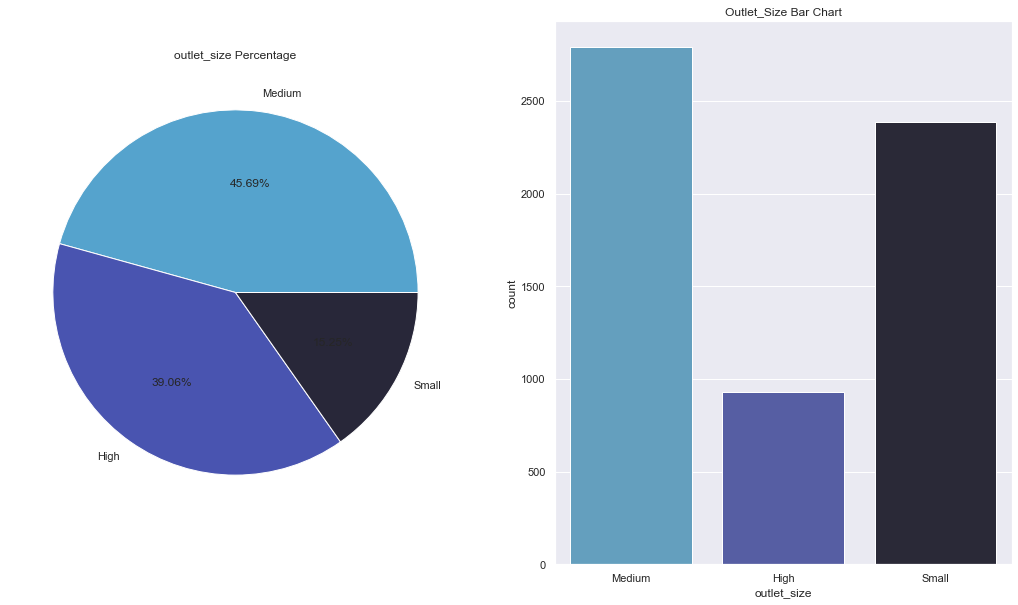

In [22]:
colors=sns.color_palette('icefire')
labels=data['outlet_size'].dropna().unique()

plt.figure(figsize=(18,10))

plt.subplot(1,2,1)
plt.title('outlet_size Percentage')
plt.pie(data['outlet_size'].value_counts(), 
        labels=labels, 
        colors=colors, 
        autopct='%.2f%%')

plt.subplot(1,2,2)
plt.title('Outlet_Size Bar Chart')
sns.countplot(x="outlet_size", data=data, palette=colors)

data.outlet_size.value_counts(dropna=False)

In [23]:
pd.DataFrame(data.loc[data['outlet_size'].isnull(),'item_outlet_sales'].describe())

,item_outlet_sales
count,2410.000000
mean,1822.626947
std,1557.858015
min,33.290000
25%,554.777850
50%,1443.454400
75%,2681.509500
max,9664.752800


In [24]:
pd.DataFrame(data.loc[data['outlet_size'] == "Medium",'item_outlet_sales'].describe())

,item_outlet_sales
count,2793.000000
mean,2681.603542
std,1855.210528
min,69.243200
25%,1270.346400
50%,2251.069800
75%,3691.195200
max,13086.964800


In [25]:
pd.DataFrame(data.loc[data['outlet_size'] == "Small",'item_outlet_sales'].describe())

,item_outlet_sales
count,2388.000000
mean,1912.149161
std,1582.370364
min,33.955800
25%,601.050950
50%,1544.656000
75%,2824.323600
max,9779.936200


In [26]:
pd.DataFrame(data.loc[data['outlet_size'] == "High",'item_outlet_sales'].describe())

,item_outlet_sales
count,932.000000
mean,2298.995256
std,1533.531664
min,73.238000
25%,1072.603800
50%,2050.664000
75%,3166.378350
max,10256.649000


You can see that the missing values in the Outlet_size column are products that the sales average and standard deviation are the same for outlet_size = small.

# 5.Data engineering:

### handel missing values;

We saw that the missing values in the Outlet_size column are products that the sales average and standard deviation are the same for outlet_size = small. Therefore I chose to fill the missing values with the value "small", instead of the common outlet_size, medium.
In addition, i filled the na in item_weight with the median value. 

In [27]:
data['item_weight'].fillna(data['item_weight'].median(), inplace=True)
data['outlet_size'].fillna("Small",inplace=True)

In [28]:
data.isna().mean()

item_identifier              0.0
item_weight                  0.0
item_fat_content             0.0
item_visibility              0.0
item_type                    0.0
item_mrp                     0.0
outlet_identifier            0.0
outlet_establishment_year    0.0
outlet_size                  0.0
outlet_location_type         0.0
outlet_type                  0.0
item_outlet_sales            0.0
dtype: float64

C:\Users\chris\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


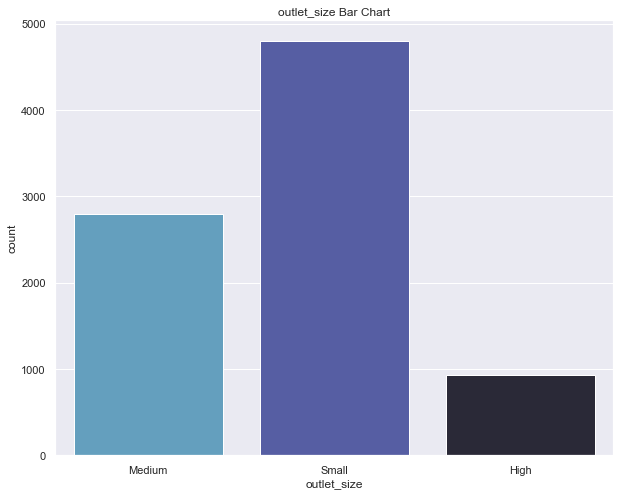

In [29]:
plt.figure(figsize=(10,8))
plt.title('outlet_size Bar Chart')
sns.countplot("outlet_size", data=data, palette=colors);

# Feater Engineering

I noticed that the minimum value of the item_visibility is 0, which  makes no sense. I will impute it with mean visibility of the product.

In [30]:
data['item_visibility']=data['item_visibility'].replace(0,data['item_visibility'].mean())
data['item_visibility'].describe()

count    8523.000000
mean        0.070213
std         0.048742
min         0.003575
25%         0.033085
50%         0.062517
75%         0.094585
max         0.328391
Name: item_visibility, dtype: float64

In [31]:
pd.DataFrame(data.loc[data['item_identifier'].str.contains("FD"),:]["item_type"].sample(10))

,item_type
3675,Snack Foods
2971,Fruits and Vegetables
6326,Fruits and Vegetables
3163,Snack Foods
5620,Snack Foods
1513,Frozen Foods
4685,Dairy
5144,Snack Foods
4588,Frozen Foods
959,Canned


In [32]:
pd.DataFrame(data.loc[data['item_identifier'].str.contains("DR"),:]["item_type"].sample(10))

,item_type
4835,Soft Drinks
4498,Dairy
4311,Snack Foods
2963,Meat
3460,Dairy
1381,Hard Drinks
5663,Dairy
7952,Soft Drinks
7459,Soft Drinks
3470,Baking Goods


 It can be seen that for item ID in the "Item_Identifier" column that starts with character "DR" will be classified as "Drink, "FD" will be classified as "Food", and "NC" will be classified as "Non-Consumable". So I’ve used the Item_Identifier variable to create a new column:

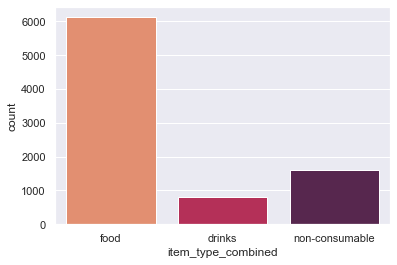

food              6125
non-consumable    1599
drinks             799
Name: item_type_combined, dtype: int64

In [33]:
data['item_type_combined'] = data['item_identifier'].apply(lambda x: x[0:2])
data['item_type_combined'] = data['item_type_combined'].map({'FD':'food','NC':'non-consumable','DR':'drinks'})
sns.countplot(x="item_type_combined", data=data, palette="rocket_r")
plt.show()
data['item_type_combined'].value_counts()

I wanted to make a new column depicting the years of operation of a store.

In [34]:
todays_date = date.today()

In [35]:
data['outler_years'] = todays_date.year - data['outlet_establishment_year']
data['outler_years'].describe()

count    8523.000000
mean       24.168133
std         8.371760
min        13.000000
25%        18.000000
50%        23.000000
75%        35.000000
max        37.000000
Name: outler_years, dtype: float64

This shows stores which are 13-37 years old

We saw that there are inconsistent values have the same meaning but in different values, such as “LF”, “low fat”, and “reg”.

In [36]:
data['item_fat_content'] = data['item_fat_content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
data['item_fat_content'].value_counts()

Low Fat    5517
Regular    3006
Name: item_fat_content, dtype: int64

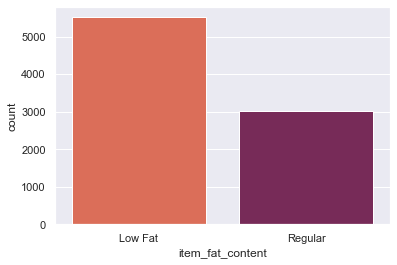

In [37]:
sns.countplot(x="item_fat_content", data=data, palette="rocket_r")
plt.show()

Now it makes more sense. But hang on, we saw there were some non-consumables as well and a fat-content should not be specified for them. So we can also create a separate category for such kind of observations.

In [38]:
data.loc[data['item_type_combined']=="non-consumable",'item_fat_content'] = "non-edible"
data['item_fat_content'].value_counts()

Low Fat       3918
Regular       3006
non-edible    1599
Name: item_fat_content, dtype: int64

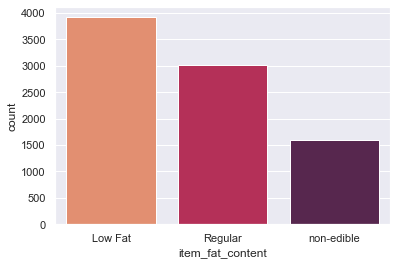

In [39]:
sns.countplot(x="item_fat_content", data=data, palette="rocket_r")
plt.show()

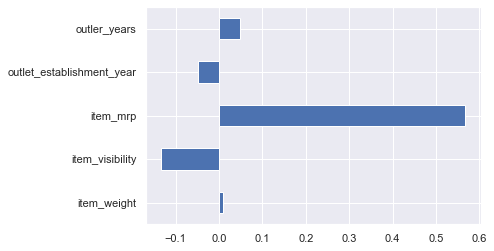

In [40]:
data.corr()['item_outlet_sales'].drop('item_outlet_sales').plot(kind='barh');

# 6.Algorithm performance

In [41]:
#Drop the columns which have been converted to different types:
data.drop(['item_type','outlet_establishment_year','item_identifier','outlet_identifier'],axis=1,inplace=True)
X = data.drop(["item_outlet_sales"], axis = 1)
y = data["item_outlet_sales"]
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=0)

# Baseline algorithm

In [42]:
def check_regressor(regressor, X_train, y_train, X_test, y_test):
    # Fit regression model
    regressor.fit(X_train, y_train)

    # Predict
    y_pred = regressor.predict(X_test)


    model_name = regressor.__class__.__name__
   


    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse, model_name

In [43]:
models_errors = {}

In [44]:
class Benchmark:
    def fit(self, x, y):
        self.value = y.mean()
        return self
    
    def predict(self, x):
        return np.ones(len(x))*self.value
    
benchmark = Benchmark()
model_rmse, model_name = check_regressor(benchmark, X_train, y_train, X_test, y_test)
models_errors[model_name] = model_rmse
print(f'{model_name} Root mean squared error is {model_rmse}')

Benchmark Root mean squared error is 1710.8444849688588


In [45]:
def encode_data(enc, data, categorical_cols, is_train=True):
    if is_train:
        transformed_data = enc.fit_transform(data[categorical_cols])
    else:
        transformed_data = enc.transform(data[categorical_cols])
    
    encoded_data = pd.DataFrame(transformed_data.toarray(), columns=enc.get_feature_names(categorical_cols)).reset_index(drop=True)
    print(encoded_data.shape)
    data_other_cols = data.drop(columns=categorical_cols).reset_index(drop=True)
    print(data_other_cols.shape)

    #Concatenate the two dataframes : 
    return pd.concat([data_other_cols, encoded_data], axis=1)

In [46]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
categorical_cols = ["item_type_combined",
                    "outlet_location_type",
                    "outlet_type",
                    "item_fat_content",
                    "outlet_size"]

encoded_train = encode_data(one_hot_encoder, X_train, categorical_cols)
encoded_test = encode_data(one_hot_encoder, X_test, categorical_cols, is_train=False)

(6818, 16)
(6818, 4)
(1705, 16)
(1705, 4)


In [47]:
encoded_train.shape, y_train.shape, encoded_test.shape, y_test.shape

((6818, 20), (6818,), (1705, 20), (1705,))

In [48]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(encoded_train)
x_test_scaled = scaler.transform(encoded_test)

# 6. Algorithm performance

In [49]:
LR = LinearRegression()
model_rmse, model_name = check_regressor(LR, encoded_train, y_train, encoded_test, y_test)
models_errors[model_name] = model_rmse

## 6.b.1-KNN

In [50]:
lst_KNN = []
for k in range(1,7,2):
    knn_reg = KNeighborsRegressor(n_neighbors=k)
    model_rmse, model_name = check_regressor(knn_reg, encoded_train, y_train, encoded_test, y_test)
    lst_KNN.append(model_rmse)
    models_errors[model_name] = min(lst_KNN)
    print(f'When k is {k}, {model_name} Root mean squared error is {model_rmse}')

When k is 1, KNeighborsRegressor Root mean squared error is 1547.5934117832132
When k is 3, KNeighborsRegressor Root mean squared error is 1324.8497988998224
When k is 5, KNeighborsRegressor Root mean squared error is 1275.4679962480639


When KNN unnormalized, K with the lowest RMSE is 5.

## 6.b.2- scaled KNN

In [51]:
lst_KNN = []
for k in range(1,7,2):
    knn_reg = KNeighborsRegressor(n_neighbors = k)
    model_rmse, model_name = check_regressor(knn_reg, x_train_scaled, y_train, x_test_scaled, y_test)
    lst_KNN.append(model_rmse)
    models_errors[model_name] = min(lst_KNN)
    print(f'When k is {k}, {model_name} Root mean squared error is {model_rmse}')

When k is 1, KNeighborsRegressor Root mean squared error is 1474.348872142876
When k is 3, KNeighborsRegressor Root mean squared error is 1253.6970934023245
When k is 5, KNeighborsRegressor Root mean squared error is 1185.7503679908111


When KNN normalized, k with the lowest RMSE is also 5, but in this case RMSE is lower than our last model when KNN was not normalized.

## 6.b.3- Decision tree 

In [52]:
lst_Dt = []
for depth in range(1,10):
    DecisionTree_reg = DecisionTreeRegressor(max_depth = depth, random_state = 0)
    model_rmse, model_name = check_regressor(DecisionTree_reg, encoded_train, y_train, encoded_test, y_test)  
    lst_Dt.append(model_rmse)
    models_errors[model_name] = min(lst_Dt) 
    print(f'When Max_depth is {depth}, {model_name} Root mean squared error is {model_rmse}')

When Max_depth is 1, DecisionTreeRegressor Root mean squared error is 1497.117232156462
When Max_depth is 2, DecisionTreeRegressor Root mean squared error is 1277.5719981720463
When Max_depth is 3, DecisionTreeRegressor Root mean squared error is 1163.681823957508
When Max_depth is 4, DecisionTreeRegressor Root mean squared error is 1113.6156460342818
When Max_depth is 5, DecisionTreeRegressor Root mean squared error is 1095.069011872778
When Max_depth is 6, DecisionTreeRegressor Root mean squared error is 1110.7783465786392
When Max_depth is 7, DecisionTreeRegressor Root mean squared error is 1130.1588820002125
When Max_depth is 8, DecisionTreeRegressor Root mean squared error is 1153.0412981439622
When Max_depth is 9, DecisionTreeRegressor Root mean squared error is 1177.321937732199


As you can see, the best max depth that gives us the lowest RMSE is 5. 

## 6.b.4- Random Forest

In [53]:
lst_Rf = []
for estimators in range(1,9,2):
    RandomForest_Reg = RandomForestRegressor(max_depth = estimators, random_state = 0,  n_estimators=100)
    model_rmse, model_name = check_regressor(RandomForest_Reg, encoded_train, y_train, encoded_test, y_test)
    lst_Rf.append(model_rmse)
    models_errors[model_name] = min(lst_Rf) 
    print(f'When Max_depth is {estimators}, {model_name} Root mean squared error is {model_rmse}')

When Max_depth is 1, RandomForestRegressor Root mean squared error is 1483.0602955448687
When Max_depth is 3, RandomForestRegressor Root mean squared error is 1148.3352008322274
When Max_depth is 5, RandomForestRegressor Root mean squared error is 1091.515042132118
When Max_depth is 7, RandomForestRegressor Root mean squared error is 1093.0041299203558


Best max depth for randomforest that get us the lowest RMSE is 5. 

## 6.b.5- Ada Boost

In [54]:
lst_Ad = []
for max_depth in range(1,8):
    base_estimator = DecisionTreeRegressor(max_depth=max_depth)
    ada_boost = AdaBoostRegressor(random_state=0, n_estimators=100, base_estimator=base_estimator)
    model_rmse, model_name = check_regressor(ada_boost, encoded_train, y_train, encoded_test, y_test)
    lst_Ad.append(model_rmse)
    models_errors[model_name] = min(lst_Ad) 
    print(f'When Max_depth is {max_depth}, {model_name} Root mean squared error is {model_rmse}')

When Max_depth is 1, AdaBoostRegressor Root mean squared error is 1522.0081886755142
When Max_depth is 2, AdaBoostRegressor Root mean squared error is 1428.6961921745738
When Max_depth is 3, AdaBoostRegressor Root mean squared error is 1187.4669158476177
When Max_depth is 4, AdaBoostRegressor Root mean squared error is 1116.1027215966287
When Max_depth is 5, AdaBoostRegressor Root mean squared error is 1353.641811777098
When Max_depth is 6, AdaBoostRegressor Root mean squared error is 1288.6735959069822
When Max_depth is 7, AdaBoostRegressor Root mean squared error is 1198.7328712284095


As you can see, the vest max depth for Adaboostregressor is 4 in this case. when ax depth is 4 we get the lowest score of RMSE.

## 6.b.6- Lasso

In [55]:
lst_lasso = []
alpha = [0.01,0.05,0.5,0.07,0.1,0.3,0.2,0.7]
alpha = sorted(alpha)
for alpha in alpha:
    lasso_reg = Lasso(alpha=alpha)
    model_rmse, model_name = check_regressor(lasso_reg, x_train_scaled, y_train, x_test_scaled, y_test)
    lst_lasso.append(model_rmse)
    models_errors[model_name] = min(lst_lasso) 
    print(f'Alpha is {alpha}, {model_name} Root mean squared error is {model_rmse}')

Alpha is 0.01, Lasso Root mean squared error is 1130.1764405477195
Alpha is 0.05, Lasso Root mean squared error is 1130.166083556436
Alpha is 0.07, Lasso Root mean squared error is 1130.1609889316724
Alpha is 0.1, Lasso Root mean squared error is 1130.1538692314218
Alpha is 0.2, Lasso Root mean squared error is 1130.13318387916
Alpha is 0.3, Lasso Root mean squared error is 1130.1243139183582
Alpha is 0.5, Lasso Root mean squared error is 1130.1074289554404
Alpha is 0.7, Lasso Root mean squared error is 1130.107166060584


When Alpha is 0.7, we get the lowest RMSE score. 

In [56]:
pd.Series(models_errors, name='Root mean squared error').sort_values().to_frame()

,Root mean squared error
RandomForestRegressor,1091.515042
DecisionTreeRegressor,1095.069012
AdaBoostRegressor,1116.102722
Lasso,1130.107166
LinearRegression,1130.179258
KNeighborsRegressor,1185.750368
Benchmark,1710.844485


# 7.Algorithm introspection 

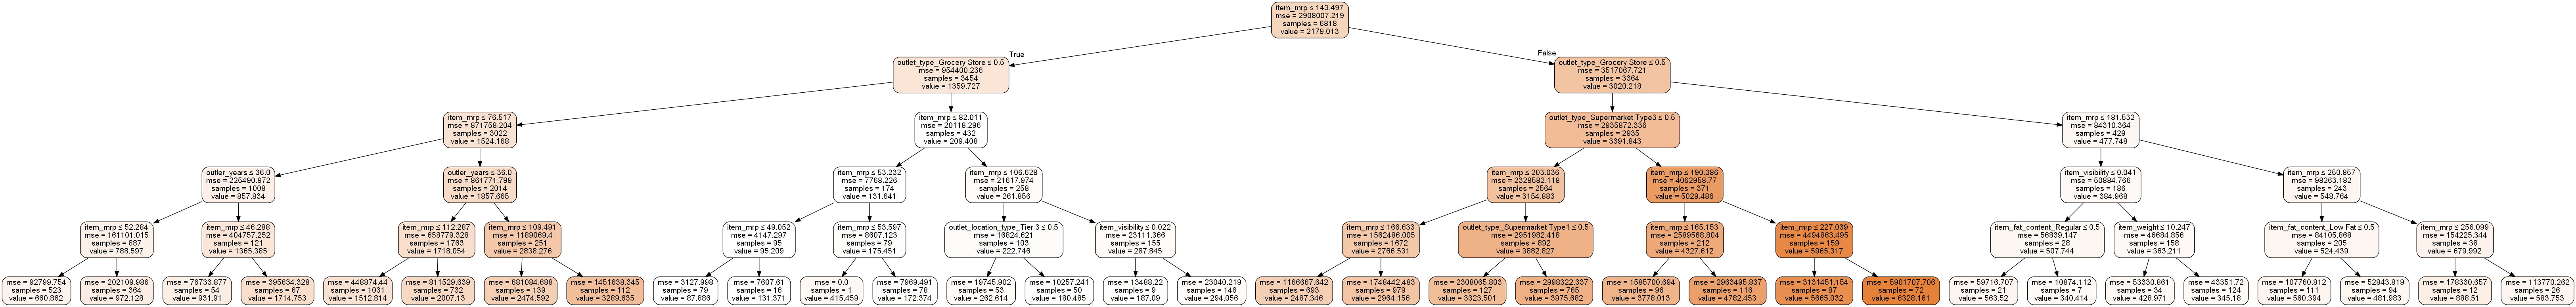

In [57]:
import pydotplus
from six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image  
DecisionTree_reg = DecisionTreeRegressor(max_depth=5)
DecisionTree_reg.fit(encoded_train, y_train)
dot_data = StringIO()
export_graphviz(DecisionTree_reg, 
                out_file=dot_data,  
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names = list(encoded_train.columns))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

You can see that my tree root is item_mrp. In addition you can see that we have 32 leavs in the tree and there is even one pure leaf with one sample. The lowest error is 7607 but if we take out a root mesa we will see the RMSE  87.21 and it has about 16 samples.

### random forest feature importance

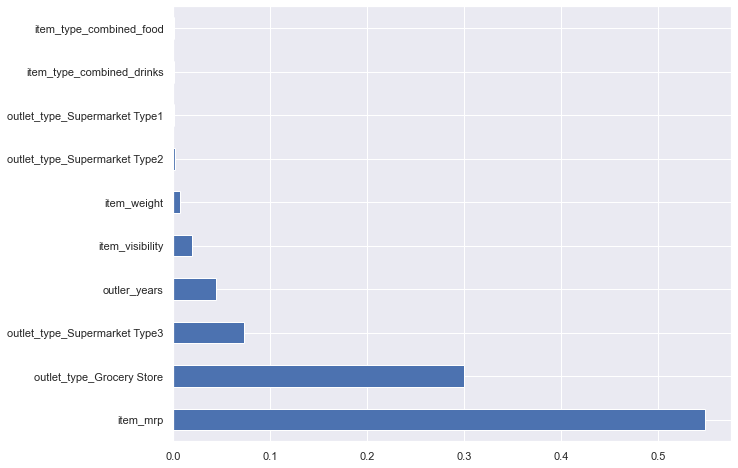

In [58]:
#plot the 10 most important features randomforest.
plt.figure(figsize=(10,8))
feat_importances = pd.Series(RandomForest_Reg.feature_importances_, index = encoded_train.columns)
feat_importances.nlargest(10).plot(kind='barh');

Feature Importance - From the feature importance, we can see item_mrp is the most impotent feature Then we have outlet_type, outlet_years(feater i created), item_visibility, item weight in order.

# 8.Hyperparameters:

In [59]:
def get_best_score(grid):
    return pd.Series(grid.best_params_, name='best_params GridSearch').to_frame()

In [60]:
def get_rmse(y_test, y_pred):
     return round(np.sqrt(mean_squared_error(y_test, y_pred)),4)

In [61]:
score_calc = 'neg_root_mean_squared_error'
RFR= RandomForestRegressor(random_state=0)
params = {'max_depth': [2,4,5,10,7],
          'min_samples_split' : [3,4,6,10],
          'n_estimators' : [70,100]}
cv_rf = GridSearchCV(RFR,
                      param_grid=params,
                      cv=3,
                     scoring = score_calc)
cv_rf.fit(encoded_train, y_train)
y_pred = cv_rf.predict(encoded_test)

In [62]:
get_best_score(cv_rf)

,best_params GridSearch
max_depth,5
min_samples_split,10
n_estimators,70


In [63]:
models_errors["grid_RF"] = get_rmse(y_test, y_pred)

In [64]:
DT=  DecisionTreeRegressor(random_state = 0)
params = {"max_depth" : [5,7,9,11,12],
         "min_samples_leaf":[1,2,3,4,5],
         "max_leaf_nodes":[None,10,20,30]}
cv_dt = GridSearchCV(DT,
                      param_grid=params,
                      cv=5,
                     scoring = score_calc)
cv_dt.fit(encoded_train, y_train)
y_pred = cv_dt.predict(encoded_test)

In [65]:
get_best_score(cv_dt)

,best_params GridSearch
max_depth,5
max_leaf_nodes,20
min_samples_leaf,5


In [66]:
models_errors["grid_DT"] = get_rmse(y_test, y_pred)

In [67]:
pd.Series(models_errors, name='Root mean squared error').sort_values().to_frame()

,Root mean squared error
RandomForestRegressor,1091.515042
grid_RF,1092.197500
grid_DT,1094.847000
DecisionTreeRegressor,1095.069012
AdaBoostRegressor,1116.102722
Lasso,1130.107166
LinearRegression,1130.179258
KNeighborsRegressor,1185.750368
Benchmark,1710.844485


As it can be seen, after using the best performing algorithm you found and looking for the hyper parameters of the algorithm that best improves the test performance. Still the RMSE is lower that the best score from before. 

# 9.Additional analysis 

### b.

In [68]:
RF = RandomForestRegressor(max_depth = 5, random_state = 0,  n_estimators=70)
RF.fit(encoded_train, y_train)
y_pred_0 = RF.predict(encoded_test)

In [69]:
Ada = DecisionTreeRegressor(max_depth=5)
Ada = AdaBoostRegressor(base_estimator=Ada, n_estimators=100, random_state=0)
Ada.fit(encoded_train, y_train)
y_pred_1 = Ada.predict(encoded_test)

In [70]:
Dt = DecisionTreeRegressor(max_depth=5)
Dt.fit(encoded_train, y_train)
y_pred_2 = Dt.predict(encoded_test)

In [71]:
y_pred = np.round(np.mean(np.array([y_pred_0, y_pred_1, y_pred_2]), axis=0))

In [72]:
models_errors["average_of_the_models "] = get_rmse(y_test, y_pred)

In [73]:
pd.Series(models_errors, name='Root mean squared error').sort_values().to_frame()

,Root mean squared error
RandomForestRegressor,1091.515042
grid_RF,1092.197500
grid_DT,1094.847000
DecisionTreeRegressor,1095.069012
AdaBoostRegressor,1116.102722
average_of_the_models,1121.518400
Lasso,1130.107166
LinearRegression,1130.179258
KNeighborsRegressor,1185.750368
Benchmark,1710.844485
